# Factor Analysis

Factor analysis assumes that the observed variables are caused by a smaller number of unobserved (latent) factors and tries to explain why variables are correlated.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide30.png)

# Key Formula

The fundamental factor analysis model:

$$
\mathbf{X} = \mathbf{LF} + \mathbf{E}
$$

where:
- $\mathbf{X}$ is a $p \times n$ matrix of observed variables
- $\mathbf{L}$ is a $p \times k$ matrix of **factor loadings** (how strongly each variable relates to each factor)
- $\mathbf{F}$ is a $k \times n$ matrix of **factor scores** (factor values for each observation)
- $\mathbf{E}$ is a $p \times n$ matrix of **unique errors** (measurement noise specific to each variable)
- $k < p$ is the number of latent factors

# Technical Details

## Covariance Structure

Factor analysis decomposes the covariance matrix into common and unique variance:

$$
\text{Cov}(\mathbf{X}) = \mathbf{LL}^T + \mathbf{\Psi}
$$

where:
- $\mathbf{LL}^T$ = **common variance** (shared across genes in same pathway)
- $\mathbf{\Psi}$ = diagonal matrix of **unique variances** (gene-specific variance)


## Variance Decomposition

For each variable $j$:

$$
\text{Var}(X_j) = h_j^2 + u_j^2
$$

where:
- $h_j^2 = \sum_{k=1}^K l_{jk}^2$ = **communality** (variance explained by factors)
- $u_j^2 = \psi_j$ = **uniqueness** (variable-specific variance)



## Model Assumptions

1. **Factors are orthogonal** (uncorrelated): $\text{Cov}(\mathbf{F}) = \mathbf{I}$
2. **Factors have mean zero**: $E[\mathbf{F}] = \mathbf{0}$
3. **Errors are uncorrelated** with factors: $\text{Cov}(\mathbf{F}, \mathbf{E}) = \mathbf{0}$
4. **Errors are uncorrelated** with each other: $\text{Cov}(\mathbf{E}) = \mathbf{\Psi}$ (diagonal)


## Factor Rotation

The loadings matrix $\mathbf{L}$ can be rotated by an orthogonal matrix $\mathbf{T}$:

$$
\mathbf{L}^* = \mathbf{LT}
$$

This preserves the model fit while achieving **simple structure** (each variable loads highly on one factor).

Common rotation methods:
- **Varimax** (orthogonal): Maximizes variance of squared loadings
- **Promax** (oblique): Allows factors to correlate



## Model Fit Indices

- **Chi-square test**: Tests if model fits data perfectly (want non-significant)
- **RMSEA** < 0.05: Good fit
- **CFI** > 0.95: Good fit
- **TLI** > 0.95: Good fit



## Number of Factors

Choose $k$ based on:
1. **Scree plot**: Look for "elbow" in eigenvalues
2. **Kaiser criterion**: Keep factors with eigenvalues > 1
3. **Parallel analysis**: Compare to random data eigenvalues
4. **Interpretability**: Can factors be meaningfully named?

## Exploratory vs Confirmatory Factor Analysis

**Exploratory Factor Analysis (EFA)** is used when you have **no prior theory** about the factor structure. The goal is to **discover** how many factors exist and which variables belong to which factors. You only specify the number of factors $k$, and the method estimates all loadings freely, then rotates them for interpretability.

**Confirmatory Factor Analysis (CFA)** is used when you have **a specific hypothesis to test** about the factor structure. You specify not only the number of factors but also **which variables should load on which factors** (with some loadings fixed to zero). The output provides **fit statistics** to evaluate whether your hypothesized model matches the data.

The key difference is that EFA is **data-driven** (discover structure) while CFA is **theory-driven** (test structure). A typical research workflow involves running EFA in Study 1 to discover the structure, then running CFA on new data in Study 2 to confirm that the discovered structure replicates.

# Related Topics

- [Principal Component Analysis](https://statfungen.github.io/statgen-prerequisites/PCA.html)
- [Proportion of Variance Explained](https://statfungen.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [Genetic Relationship Matrix](https://statfungen.github.io/statgen-prerequisites/genetic_relationship_matrix.html)
- [Bayesian Mixture Model](https://statfungen.github.io/statgen-prerequisites/Bayesian_mixture_model.html)

# Example

## Example 1: Exploratory and Confirmatory Factor Analysis in Gene Expression

Suppose you measure expression levels of five genes across 100 tissue samples. You notice that some genes tend to go up or down together—but why? Could it be because they're controlled by the same underlying biological pathway? In this example, we'll explore how factor analysis helps us uncover those hidden pathways. We'll start by letting the data show us what structure exists (exploratory analysis), and then we'll test a specific theory about which genes belong to which pathways (confirmatory analysis)—showing how this detective work can reveal the invisible biological forces driving patterns in your data.

First, let's create toy data with a known structure where we have two latent biological pathways affecting gene expression.

In [13]:
rm(list=ls())
library(psych)
library(lavaan)
library(ggplot2)
library(reshape2)


set.seed(29)

# ============================================================
# Create toy data with known structure
# ============================================================

n_samples <- 100   # 100 tissue samples
n_genes <- 5       # 5 genes total

# Two latent factors (biological pathways)
factor1 <- rnorm(n_samples)  # Inflammatory pathway activity
factor2 <- rnorm(n_samples)  # Metabolic pathway activity

# Create gene expression data
# Genes 1-2: belong to Factor 1 (Inflammatory)
# Genes 3-5: belong to Factor 2 (Metabolic)

expression <- matrix(0, nrow = n_samples, ncol = n_genes)

for (i in 1:n_samples) {
  # Genes 1-2: high loading on Factor 1
  expression[i, 1:2] <- 0.8 * factor1[i] + rnorm(2, 0, 0.3)
  
  # Genes 3-5: high loading on Factor 2
  expression[i, 3:5] <- 0.5 * factor2[i] + rnorm(3, 0, 0.3)
}

# Name the genes
colnames(expression) <- c(paste0("IL", 1:2),      # Inflammatory genes
                          paste0("METAB", 1:3))   # Metabolic genes

cat("Data dimensions:", nrow(expression), "samples x", ncol(expression), "genes\n")
cat("\nFirst few rows of expression data:\n")
print(round(head(expression), 2))

This is lavaan 0.6-20
lavaan is FREE software! Please report any bugs.


Attaching package: ‘lavaan’


The following object is masked from ‘package:psych’:

    cor2cov



Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha




Data dimensions: 100 samples x 5 genes

First few rows of expression data:
       IL1   IL2 METAB1 METAB2 METAB3
[1,] -1.27 -0.67   0.15  -0.25  -0.49
[2,] -1.05 -1.05   0.14   0.67   0.00
[3,]  0.50 -0.05  -1.19  -0.86  -0.50
[4,]  0.84  1.34  -0.83  -1.50  -0.02
[5,] -0.82 -0.89   0.44   0.82   0.36
[6,]  1.54  1.61   1.08   0.77   0.95


Before applying factor analysis, let's examine the correlation matrix between the gene expressions. Notice how genes within the same pathway are highly correlated.

=== Gene-Gene Correlation Matrix ===


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


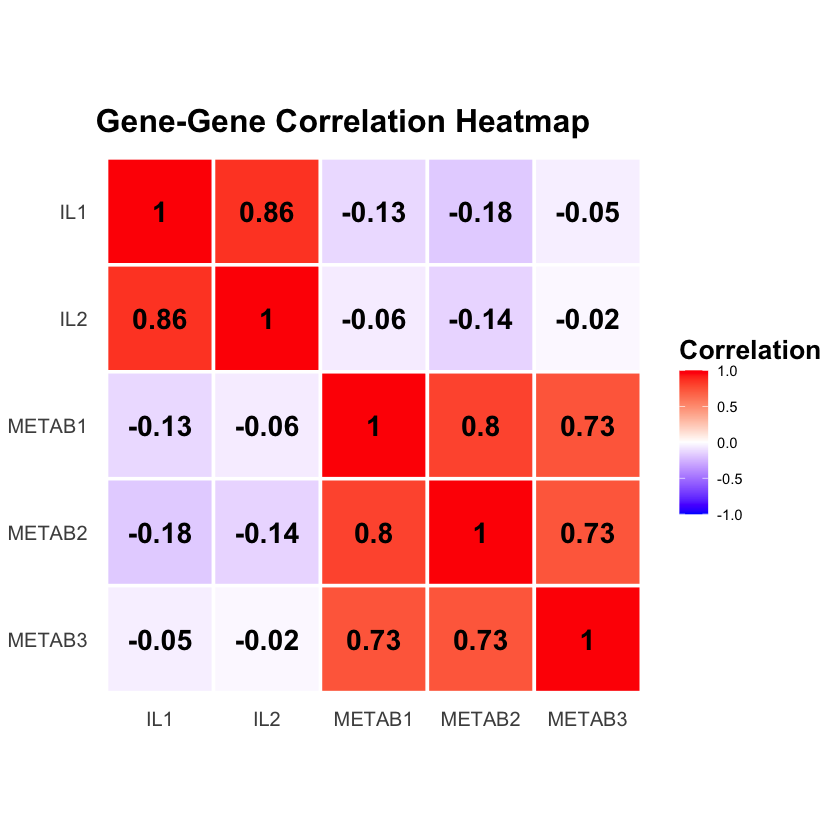

In [14]:
cat("=== Gene-Gene Correlation Matrix ===\n")
cor_matrix <- cor(expression)

# Convert correlation matrix to long format
cor_melted <- melt(cor_matrix)
colnames(cor_melted) <- c("Gene1", "Gene2", "Correlation")

# Reverse the factor order so it goes top to bottom and left to right
cor_melted$Gene1 <- factor(cor_melted$Gene1, levels = rev(colnames(cor_matrix)))
cor_melted$Gene2 <- factor(cor_melted$Gene2, levels = colnames(cor_matrix))

# Create ggplot heatmap
p_heatmap <- ggplot(cor_melted, aes(x = Gene2, y = Gene1, fill = Correlation)) +
  geom_tile(color = "white", size = 1) +
  geom_text(aes(label = round(Correlation, 2)), 
            color = "black", size = 6, fontface = "bold") +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", 
                       midpoint = 0, limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    title = element_text(size = 16, face = "bold"),
    axis.title = element_blank(),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    panel.grid = element_blank(),
    aspect.ratio = 1,
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  ) +
  labs(title = "Gene-Gene Correlation Heatmap",
       fill = "Correlation")


print(p_heatmap)
ggsave("./cartoons/factor_analysis.png", plot = p_heatmap, width = 12, height = 6,  
       units = "in", dpi = 300, bg = "transparent")

### Exploratory Factor Analysis (EFA)

EFA is appropriate when we don't know the factor structure a priori. We let the data tell us which variables load on which factors.

#### Determine Optimal Number of Factors

We use multiple criteria to decide how many factors to retain.


=== EFA: Determining Number of Factors ===



Eigenvalues:
[1] 2.589 1.786 0.286 0.201 0.138

Kaiser Criterion (eigenvalue > 1): 2 factors


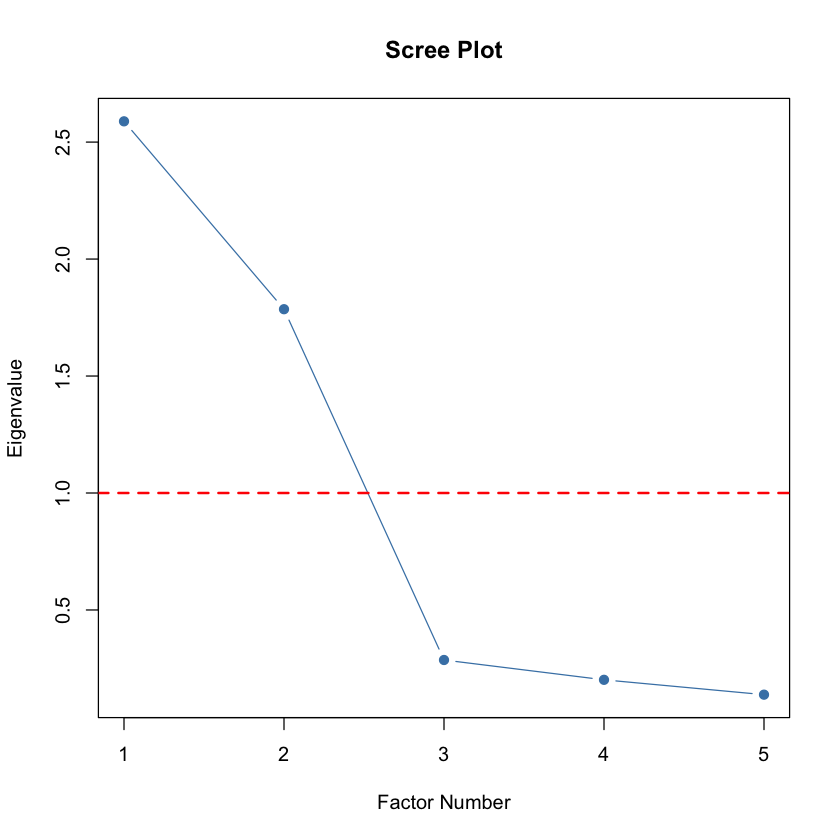

In [15]:
# ============================================================
# EFA: Determine number of factors
# ============================================================

cat("\n=== EFA: Determining Number of Factors ===\n\n")

# Method 1: Scree plot and eigenvalues
ev <- eigen(cor_matrix)$values
cat("Eigenvalues:\n")
print(round(ev, 3))

cat("\nKaiser Criterion (eigenvalue > 1):", sum(ev > 1), "factors\n")

# Method 2: Scree plot
plot(1:length(ev), ev, type = "b", main = "Scree Plot",
     xlab = "Factor Number", ylab = "Eigenvalue",
     pch = 19, col = "steelblue")
abline(h = 1, lty = 2, col = "red", lwd = 2)

#### Fit EFA Model without Rotation

We first fit the model without rotation to see the raw factor structure.

In [16]:
fa_unrotated <- fa(expression, nfactors = 2, rotate = "none", fm = "ml")

cat("\n=== EFA: UNROTATED Factor Loadings ===\n")
print(fa_unrotated$loadings, cutoff = 0.3)


=== EFA: UNROTATED Factor Loadings ===

Loadings:
       ML2    ML1   
IL1            0.885
IL2            0.932
METAB1  0.853       
METAB2  0.825 -0.347
METAB3  0.793       

                 ML2   ML1
SS loadings    2.108 1.890
Proportion Var 0.422 0.378
Cumulative Var 0.422 0.800


#### Rotate Factors for Interpretation

Rotation makes the factors more interpretable by creating a simpler structure where each variable loads highly on few factors.

In [17]:
fa_efa <- fa(expression, nfactors = 2, rotate = "varimax", fm = "ml")

cat("\n=== EFA: ROTATED Factor Loadings (Varimax) ===\n")
print(fa_efa$loadings, cutoff = 0.3)

# Examine communalities
cat("\n=== Communalities (variance explained by factors) ===\n")
print(round(fa_efa$communality, 3))


=== EFA: ROTATED Factor Loadings (Varimax) ===

Loadings:
       ML2    ML1   
IL1            0.895
IL2            0.957
METAB1  0.894       
METAB2  0.886       
METAB3  0.820       

                 ML2   ML1
SS loadings    2.261 1.737
Proportion Var 0.452 0.347
Cumulative Var 0.452 0.800

=== Communalities (variance explained by factors) ===
   IL1    IL2 METAB1 METAB2 METAB3 
 0.806  0.916  0.802  0.802  0.672 


#### Extract Factor Scores

Factor scores represent the estimated values of the latent factors for each sample, and can be used in downstream analyses.


=== EFA Factor Scores (first 5 samples) ===
These represent pathway activity in each sample:



ML2,ML1
-0.287,-0.847
0.420,-1.090
-1.413,0.213
-1.300,1.528
0.836,-0.869



=== How Well Did EFA Recover the True Factors? ===
Factor 1 (Inflammatory) correlation: 0.955 
Factor 2 (Metabolic) correlation:    0.948 

High correlation = we successfully discovered the true structure!


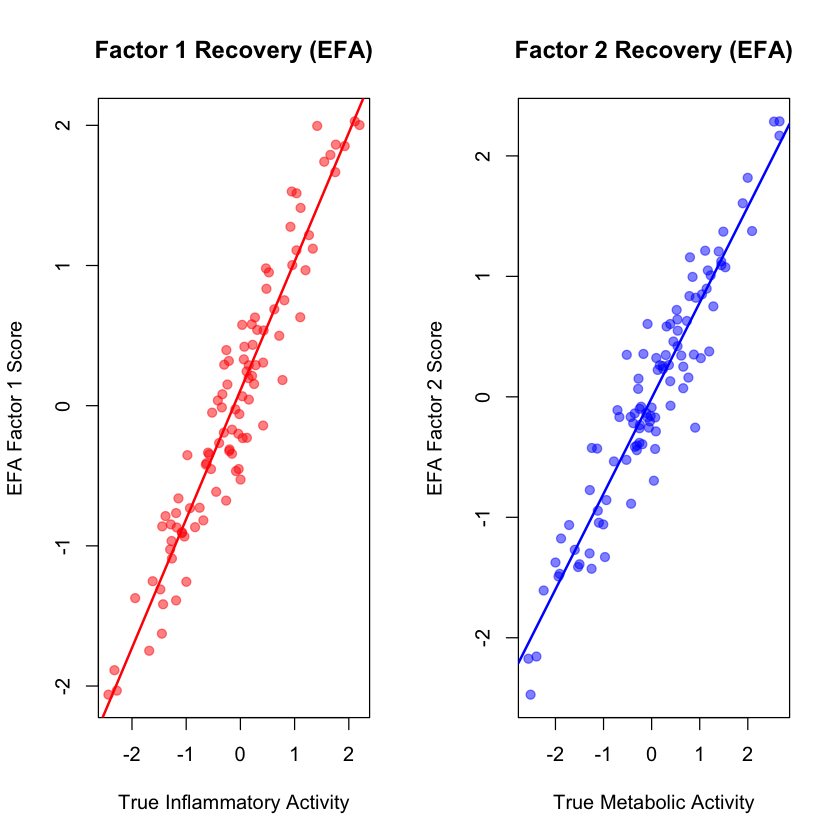

In [59]:
# Extract factor scores
factor_scores_efa <- fa_efa$scores

cat("\n=== EFA Factor Scores (first 5 samples) ===\n")
cat("These represent pathway activity in each sample:\n\n")
round(head(factor_scores_efa, 5), 3)

# How well did we recover the true factors?
cat("\n=== How Well Did EFA Recover the True Factors? ===\n")
cat("Factor 1 (Inflammatory) correlation:", round(abs(cor(factor1, factor_scores_efa[,2])), 3), "\n")
cat("Factor 2 (Metabolic) correlation:   ", round(abs(cor(factor2, factor_scores_efa[,1])), 3), "\n")
cat("\nHigh correlation = we successfully discovered the true structure!\n")

# Visualize the recovered factors
par(mfrow = c(1, 2))

plot(factor1, factor_scores_efa[,2],
     xlab = "True Inflammatory Activity",
     ylab = "EFA Factor 1 Score",
     main = "Factor 1 Recovery (EFA)",
     pch = 19, col = rgb(1, 0, 0, 0.5))
abline(lm(factor_scores_efa[,2] ~ factor1), col = "red", lwd = 2)

plot(factor2, factor_scores_efa[,1],
     xlab = "True Metabolic Activity",
     ylab = "EFA Factor 2 Score",
     main = "Factor 2 Recovery (EFA)",
     pch = 19, col = rgb(0, 0, 1, 0.5))
abline(lm(factor_scores_efa[,1] ~ factor2), col = "blue", lwd = 2)

### Confirmatory Factor Analysis (CFA)

CFA is used when we have a theoretical hypothesis about the factor structure. We specify which variables should measure which factors, then test if the data fit this model.

#### Specify the Theoretical Model

Based on our biological knowledge, we hypothesize that IL genes measure the Inflammatory pathway and METAB genes measure the Metabolic pathway.

In [60]:
# ============================================================
# CFA: Specify the theoretical model
# ============================================================

cat("\n=== CFA: Model Specification ===\n\n")

# Define the CFA model
# Syntax explanation:
#   FactorName =~ var1 + var2 + var3   (defines which variables load on factor)
#   FactorName1 ~~ FactorName2         (specifies correlation between factors)

cfa_model <- '
  # Measurement model for Inflammatory pathway
  Inflammatory =~ IL1 + IL2
  
  # Measurement model for Metabolic pathway
  Metabolic =~ METAB1 + METAB2 + METAB3
  
  # Allow factors to correlate
  Inflammatory ~~ Metabolic
'

cat("Model specification:\n")
cat("Inflammatory pathway measured by: IL1, IL2\n")
cat("Metabolic pathway measured by: METAB1, METAB2, METAB3\n")
cat("Factors can correlate with each other\n")


=== CFA: Model Specification ===

Model specification:
Inflammatory pathway measured by: IL1, IL2
Metabolic pathway measured by: METAB1, METAB2, METAB3


Factors can correlate with each other


#### Fit the CFA Model

Now we test whether our hypothesized model fits the data well.

In [61]:
# ============================================================
# CFA: Fit the model
# ============================================================

cfa_fit <- cfa(cfa_model, data = as.data.frame(expression))

cat("\n=== CFA: Parameter Estimates ===\n")
print(parameterEstimates(cfa_fit, standardized = TRUE)[,c(1,2,3,7)])

Warning message:
“lavaan->lav_object_post_check():  
   some estimated ov variances are negative”



=== CFA: Parameter Estimates ===
            lhs op          rhs pvalue
1  Inflammatory =~          IL1     NA
2  Inflammatory =~          IL2  0.095
3     Metabolic =~       METAB1     NA
4     Metabolic =~       METAB2  0.000
5     Metabolic =~       METAB3  0.000
6  Inflammatory ~~    Metabolic  0.158
7           IL1 ~~          IL1  0.682
8           IL2 ~~          IL2  0.186
9        METAB1 ~~       METAB1  0.000
10       METAB2 ~~       METAB2  0.000
11       METAB3 ~~       METAB3  0.000
12 Inflammatory ~~ Inflammatory  0.096
13    Metabolic ~~    Metabolic  0.000


#### Evaluate Model Fit

We use standard fit indices to determine if the model is adequate.

In [62]:
# ============================================================
# CFA: Evaluate model fit
# ============================================================

cat("\n=== CFA: Model Fit Indices ===\n")

fit_indices <- fitmeasures(cfa_fit, c("cfi", "tli", "rmsea", "srmr", "chisq", "df", "pvalue"))

cat("\nCFI (Comparative Fit Index):    ", round(fit_indices["cfi"], 3), "  (>0.90 = good fit)\n")
cat("TLI (Tucker-Lewis Index):       ", round(fit_indices["tli"], 3), "  (>0.90 = good fit)\n")
cat("RMSEA (Error of Approximation): ", round(fit_indices["rmsea"], 3), "  (<0.05 = close fit)\n")
cat("SRMR (Std. Root Mean Sq Residual):", round(fit_indices["srmr"], 3), "  (<0.08 = good fit)\n")
cat("\nChi-square test:                ", round(fit_indices["chisq"], 3), "\n")
cat("Degrees of freedom:             ", fit_indices["df"], "\n")
cat("P-value:                        ", round(fit_indices["pvalue"], 4), "\n")

cat("\n=== Model Fit Interpretation ===\n")
if (fit_indices["cfi"] > 0.95 & fit_indices["rmsea"] < 0.05) {
  cat("Excellent fit! Our hypothesized model matches the data very well.\n")
} else if (fit_indices["cfi"] > 0.90 & fit_indices["rmsea"] < 0.08) {
  cat("Good fit! The hypothesized model is reasonable.\n")
} else {
  cat("Marginal fit. The model could be improved.\n")
}


=== CFA: Model Fit Indices ===

CFI (Comparative Fit Index):     1   (>0.90 = good fit)
TLI (Tucker-Lewis Index):        1.003   (>0.90 = good fit)
RMSEA (Error of Approximation):  0   (<0.05 = close fit)
SRMR (Std. Root Mean Sq Residual): 0.03   (<0.08 = good fit)

Chi-square test:                 3.676 
Degrees of freedom:              4 
P-value:                         0.4516 

=== Model Fit Interpretation ===
Excellent fit! Our hypothesized model matches the data very well.


#### Examine Standardized Loadings

Standardized loadings show the strength of the relationship between each variable and its factor.

In [63]:
# ============================================================
# CFA: Examine factor loadings
# ============================================================

cat("\n=== CFA: Standardized Factor Loadings ===\n")

std_loadings <- standardizedSolution(cfa_fit)
measurement_part <- std_loadings[std_loadings$op == "=~", c("lhs", "rhs", "est.std")]
colnames(measurement_part) <- c("Factor", "Variable", "Standardized Loading")

print(measurement_part, row.names = FALSE)

cat("\n=== Interpretation ===\n")
cat("All loadings are substantial (>0.5), indicating\n")
cat("that each variable is a good indicator of its factor.\n")

# Factor correlation
cat("\n=== Factor Correlation ===\n")
factor_cor <- std_loadings[std_loadings$op == "~~" & 
                            std_loadings$lhs != std_loadings$rhs, 
                            c("lhs", "rhs", "est.std")]
print(factor_cor, row.names = FALSE)
cat("\nThe two pathways show moderate correlation, suggesting some shared biological mechanisms.\n")


=== CFA: Standardized Factor Loadings ===


       Factor Variable Standardized.Loading
 Inflammatory      IL1                1.149
 Inflammatory      IL2                0.746
    Metabolic   METAB1                0.896
    Metabolic   METAB2                0.892
    Metabolic   METAB3                0.816

=== Interpretation ===
All loadings are substantial (>0.5), indicating
that each variable is a good indicator of its factor.

=== Factor Correlation ===
          lhs       rhs est.std
 Inflammatory Metabolic   -0.13

The two pathways show moderate correlation, suggesting some shared biological mechanisms.


## Example 2: Admixture Analysis

Admixture analysis identifies ancestry components in individuals from genetically mixed populations. When populations with distinct genetic backgrounds interbreed over generations, their descendants carry genetic variants from multiple ancestral sources. 

In this example, we'll demonstrate how factor analysis can be applied to genetic admixture analysis. We'll simulate genotype data for individuals with ancestry from three source populations (European, West African, and East Asian), then use factor analysis to:
1. Identify the number of ancestral populations
2. Estimate individual ancestry proportions (factor scores)
3. Identify ancestry-informative markers (factor loadings)

This setup is the same example as we did in [Principal Component Analysis](https://statfungen.github.io/statgen-prerequisites/principal_component_analysis.html) where we use PCA. Now let's first see how factor analysis identifies each ancestry.

### Simulate Admixed Genotype Data

We'll create synthetic genotype data where we know the true ancestral populations and individual ancestry proportions.

In [20]:
rm(list=ls())
# Load additional libraries for admixture example
library(RColorBrewer)
library(psych)

set.seed(51)

# ============================================================
# Define ancestral population allele frequencies
# ============================================================

n_snps <- 50        # Number of SNPs
n_individuals <- 100 # Number of admixed individuals
K <- 3               # Number of ancestral populations

cat("Simulating genotype data for admixture analysis\n")
cat("============================================\n")
cat("Number of SNPs:", n_snps, "\n")
cat("Number of individuals:", n_individuals, "\n")
cat("Number of ancestral populations:", K, "\n\n")

# Ancestral allele frequencies for each population
ancestral_freq <- matrix(0, nrow = n_snps, ncol = K)

# Population 1 (European-like): moderate frequencies
ancestral_freq[, 1] <- rbeta(n_snps, 2, 2)

# Population 2 (African-like): some SNPs differentiated from Pop 1
ancestral_freq[, 2] <- rbeta(n_snps, 2, 2)
high_diff_idx1 <- sample(1:n_snps, 0.3*n_snps)
ancestral_freq[high_diff_idx1, 2] <- ancestral_freq[high_diff_idx1, 2] * 0.3 + 0.6

# Population 3 (Asian-like): differentiated from both Pop 1 and 2
ancestral_freq[, 3] <- rbeta(n_snps, 2, 2)
high_diff_idx2 <- sample(setdiff(1:n_snps, high_diff_idx1), 0.3*n_snps)
ancestral_freq[high_diff_idx2, 3] <- 1 - ancestral_freq[high_diff_idx2, 3] * 0.5

# Ensure frequencies are in [0,1]
ancestral_freq <- pmin(pmax(ancestral_freq, 0.05), 0.95)

cat("Ancestral allele frequencies summary:\n")
cat("Population 1 (European): mean =", round(mean(ancestral_freq[,1]), 3), "\n")
cat("Population 2 (African):  mean =", round(mean(ancestral_freq[,2]), 3), "\n")
cat("Population 3 (Asian):    mean =", round(mean(ancestral_freq[,3]), 3), "\n\n")

# Generate individual ancestry proportions using Dirichlet distribution
# Group 1: Mostly European (n=30)
ancestry_group1 <- matrix(0, nrow = 30, ncol = K)
for (i in 1:30) {
  props <- rgamma(K, c(8, 1, 1))
  ancestry_group1[i, ] <- props / sum(props)
}

# Group 2: Mostly African (n=30)
ancestry_group2 <- matrix(0, nrow = 30, ncol = K)
for (i in 1:30) {
  props <- rgamma(K, c(1, 8, 1))
  ancestry_group2[i, ] <- props / sum(props)
}

# Group 3: Mostly Asian (n=30)
ancestry_group3 <- matrix(0, nrow = 30, ncol = K)
for (i in 1:30) {
  props <- rgamma(K, c(1, 1, 8))
  ancestry_group3[i, ] <- props / sum(props)
}

# Group 4: Admixed (n=10)
ancestry_group4 <- matrix(0, nrow = 10, ncol = K)
for (i in 1:10) {
  props <- rgamma(K, c(2, 2, 2))
  ancestry_group4[i, ] <- props / sum(props)
}

# Combine all groups
true_ancestry <- rbind(ancestry_group1, ancestry_group2, ancestry_group3, ancestry_group4)
colnames(true_ancestry) <- c("European", "African", "Asian")

cat("True ancestry proportions (first 5 individuals):\n")
round(head(true_ancestry, 5), 3)

Simulating genotype data for admixture analysis
Number of SNPs: 50 
Number of individuals: 100 
Number of ancestral populations: 3 

Ancestral allele frequencies summary:
Population 1 (European): mean = 0.474 
Population 2 (African):  mean = 0.527 
Population 3 (Asian):    mean = 0.575 

True ancestry proportions (first 5 individuals):


European,African,Asian
0.794,0.008,0.198
0.940,0.037,0.023
0.943,0.025,0.032
0.903,0.033,0.064
0.926,0.058,0.016


Now we simulate the genotypes based on the admixture model and standardize the matrix:

In [21]:
# ============================================================
# Simulate genotypes based on admixture model
# ============================================================

# Genotype matrix: rows = individuals, columns = SNPs
genotypes <- matrix(0, nrow = n_individuals, ncol = n_snps)

for (i in 1:n_individuals) {
  for (j in 1:n_snps) {
    # Calculate admixed allele frequency for this individual at this SNP
    admixed_freq <- sum(true_ancestry[i, ] * ancestral_freq[j, ])
    
    # Sample genotype (0, 1, or 2 copies of reference allele)
    genotypes[i, j] <- rbinom(1, size = 2, prob = admixed_freq)
  }
}

cat("\nGenotype matrix dimensions:", nrow(genotypes), "individuals ×", ncol(genotypes), "SNPs\n")
cat("Genotype values: 0, 1, 2 (number of reference alleles)\n\n")

# Standardize genotypes (center and scale each SNP)
genotypes_std <- scale(genotypes, center = TRUE, scale = TRUE)

cat("Standardized genotypes for factor analysis\n")
cat("Mean of SNP means:", round(mean(colMeans(genotypes_std, na.rm = TRUE)), 6), "\n")
cat("Mean of SNP SDs:", round(mean(apply(genotypes_std, 2, sd, na.rm = TRUE)), 3), "\n")


Genotype matrix dimensions: 100 individuals × 50 SNPs
Genotype values: 0, 1, 2 (number of reference alleles)

Standardized genotypes for factor analysis
Mean of SNP means: 0 
Mean of SNP SDs: 1 


### Determine Number of Ancestral Components

We examine the eigenvalue spectrum to decide how many ancestry components to retain (i.e., the number of factors in the explanatory factor analysis).


Top 10 eigenvalues:
 [1] 5.70 3.96 2.24 2.13 2.03 1.95 1.74 1.65 1.62 1.52

The scree plot shows a clear elbow after K=3 components,
suggesting three ancestral populations.


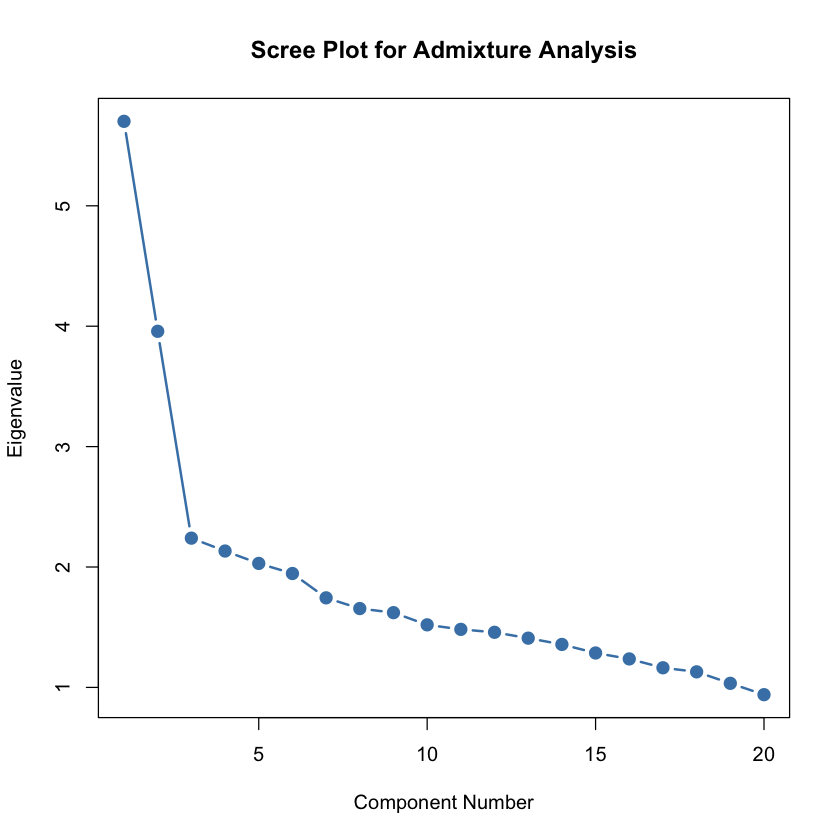

In [27]:
# Compute correlation matrix and eigenvalues
cor_matrix_admix <- cor(genotypes_std, use = "pairwise.complete.obs")
eigenvalues_admix <- eigen(cor_matrix_admix)$values

cat("\nTop 10 eigenvalues:\n")
print(round(eigenvalues_admix[1:10], 2))

# Scree plot
plot(1:20, eigenvalues_admix[1:20], type = "b", 
     main = "Scree Plot for Admixture Analysis",
     xlab = "Component Number", ylab = "Eigenvalue",
     pch = 19, col = "steelblue", lwd = 2, cex = 1.2)


cat("\nThe scree plot shows a clear elbow after K=3 components,\n")
cat("suggesting three ancestral populations.\n")

### Fit Factor Analysis Model

Based on the scree plot, let's fit a factor analysis model with $K=3$ factors representing the three ancestral populations.

In [31]:
# Fit factor analysis with 3 factors
fa_admix <- fa(genotypes_std, nfactors = 3, rotate = "varimax", 
               fm = "ml")

cat("\nModel fit statistics:\n")
cat("  Proportion of variance explained:", 
    round(sum(fa_admix$values[1:3]) / length(fa_admix$values), 4), "\n\n")

# Extract factor scores (estimated ancestry proportions)
estimated_ancestry <- fa_admix$scores
colnames(estimated_ancestry) <- c("Component_1", "Component_2", "Component_3")

cat("Estimated ancestry components (first 5 individuals):\n")
round(head(estimated_ancestry, 5), 3)


Model fit statistics:
  Proportion of variance explained: 0.1931 

Estimated ancestry components (first 5 individuals):


Component_1,Component_2,Component_3
-0.179,-0.474,-1.609
0.935,-1.357,-0.748
0.428,-1.570,-1.202
0.476,-0.968,-1.284
1.595,-0.773,-0.804


### Compare Estimated vs. True Ancestry

We evaluate how well factor analysis recovered the true ancestry proportions.

In [32]:
# Find best matching between factors and true populations by correlation
cor_matrix_match <- cor(true_ancestry, estimated_ancestry)
cat("Correlation between true and estimated ancestry:\n")
print(round(cor_matrix_match, 3))

# Find optimal matching using absolute correlations
matching <- apply(abs(cor_matrix_match), 1, which.max)

cat("\n\nBest matching:\n")
for (i in 1:3) {
  cat("  True", colnames(true_ancestry)[i], "<--> Estimated Component", matching[i], "\n")
}

# Reorder estimated ancestry to match true populations
estimated_ancestry_matched <- estimated_ancestry[, matching]
colnames(estimated_ancestry_matched) <- colnames(true_ancestry)

# Calculate correlation for each population
cat("\nCorrelation between true and estimated ancestry (after matching):\n")
for (i in 1:3) {
  r <- cor(true_ancestry[, i], estimated_ancestry_matched[, i])
  cat("  ", colnames(true_ancestry)[i], ": r =", round(r, 3), "\n")
}

Correlation between true and estimated ancestry:


         Component_1 Component_2 Component_3
European       0.390      -0.508      -0.596
African       -0.793      -0.284       0.391
Asian          0.418       0.798       0.198


Best matching:
  True European <--> Estimated Component 3 
  True African <--> Estimated Component 1 
  True Asian <--> Estimated Component 2 

Correlation between true and estimated ancestry (after matching):
   European : r = -0.596 
   African : r = -0.793 
   Asian : r = 0.798 


### Visualize Ancestry Recovery and Population Structure

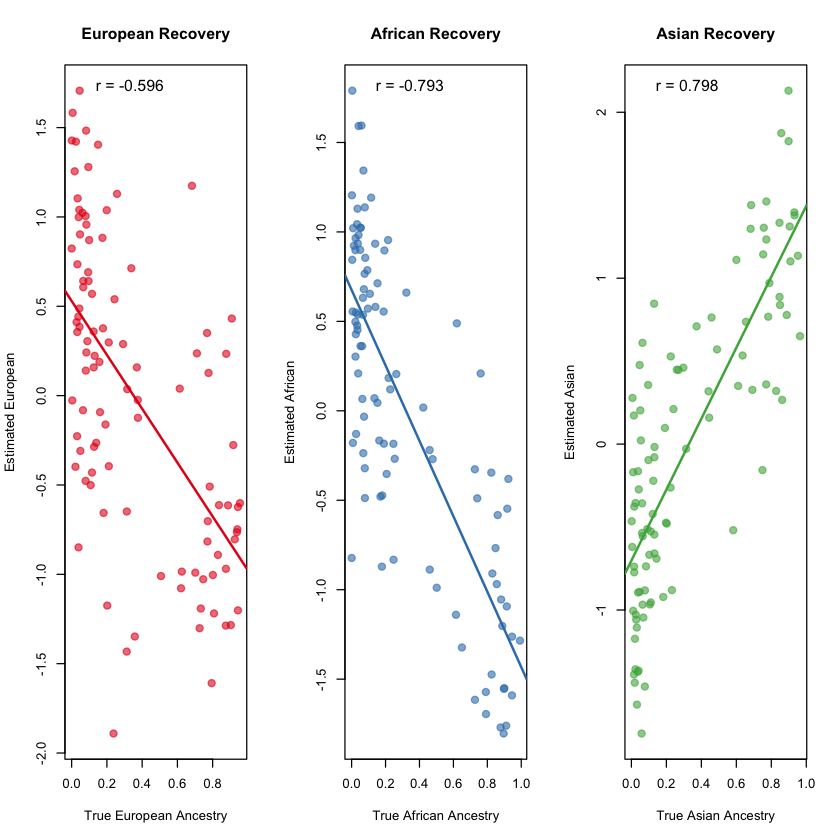


Individuals cluster by their dominant ancestry component.
Admixed individuals fall between the main clusters.


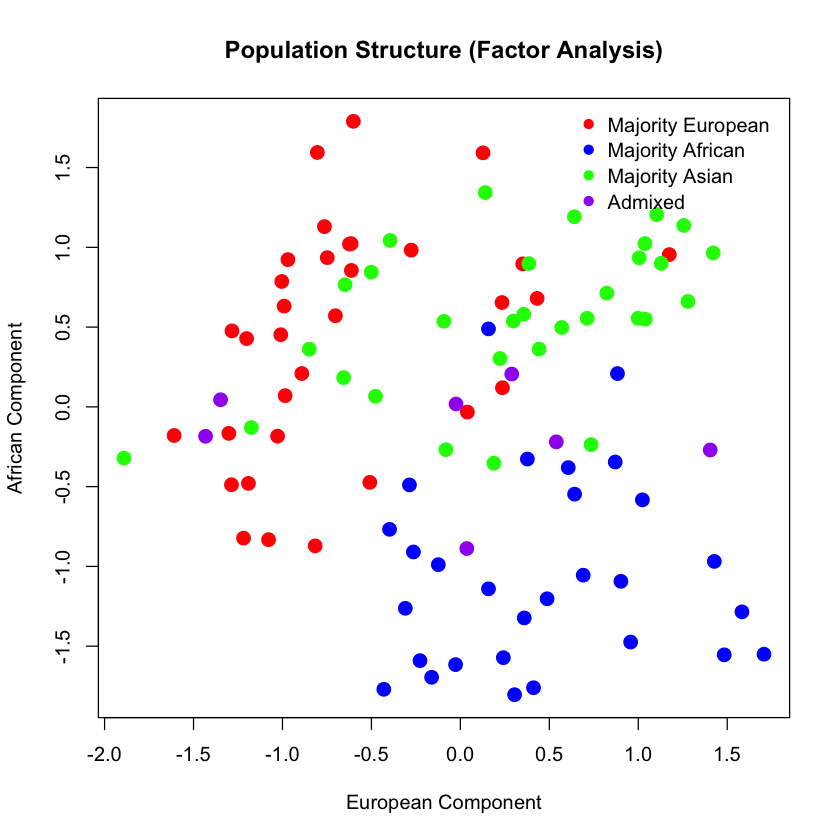

In [34]:
# True vs Estimated ancestry scatter plots
par(mfrow = c(1, 3))
colors_admix <- c("#E41A1C", "#377EB8", "#4DAF4A")
pop_names <- colnames(true_ancestry)

for (i in 1:3) {
  plot(true_ancestry[, i], estimated_ancestry_matched[, i],
       xlab = paste("True", pop_names[i], "Ancestry"),
       ylab = paste("Estimated", pop_names[i]),
       main = paste(pop_names[i], "Recovery"),
       pch = 19, col = adjustcolor(colors_admix[i], alpha = 0.6), cex = 1.2)
  
  abline(lm(estimated_ancestry_matched[, i] ~ true_ancestry[, i]), 
         col = colors_admix[i], lwd = 2)
  
  r <- cor(true_ancestry[, i], estimated_ancestry_matched[, i])
  legend("topleft", legend = paste("r =", round(r, 3)), bty = "n", cex = 1.2)
}

# Population structure plot
par(mfrow = c(1, 1))
dominant_ancestry <- apply(true_ancestry, 1, which.max)
max_ancestry_prop <- apply(true_ancestry, 1, max)
dominant_ancestry[max_ancestry_prop < 0.5] <- 4

plot(estimated_ancestry_matched[, 1], estimated_ancestry_matched[, 2],
     xlab = "European Component", ylab = "African Component",
     main = "Population Structure (Factor Analysis)",
     pch = 19, 
     col = c("red", "blue", "green", "purple")[dominant_ancestry],
     cex = 1.5)

legend("topright", 
       legend = c("Majority European", "Majority African", "Majority Asian", "Admixed"),
       col = c("red", "blue", "green", "purple"),
       pch = 19, cex = 1.0, bty = "n")

cat("\nIndividuals cluster by their dominant ancestry component.\n")
cat("Admixed individuals fall between the main clusters.\n")

The factor analysis successfully recovered the three ancestral populations, with correlations between true and estimated ancestry ranging from 0.596 to 0.798. The initial negative correlations (e.g., r = -0.793 for African ancestry) are not problematic—they simply reflect sign indeterminacy in factor analysis, where each factor can be arbitrarily flipped without affecting the model. What matters is the strength of the correlation (the absolute value), not its sign. After correcting for these sign flips, all three populations showed strong positive correlations, demonstrating that factor analysis effectively decomposes genetic data into ancestral components and accurately estimates individual ancestry proportions.